In [1]:
!pip install ultralytics

In [13]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

In [14]:
# start reading video from camera. Takes ~1 minute for me.
# You can use a built-in webcam of your laptop:
# vid = cv.VideoCapture(0)
# but it's inconvinient :)
vid = cv.VideoCapture(1)

In [15]:
# choosing ArUco dictionary
dict = cv.aruco.getPredefinedDictionary(cv.aruco.DICT_5X5_100)

(-0.5, 1919.5, 1079.5, -0.5)

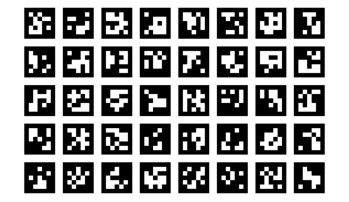

In [16]:
# creating board with ArUco markers
height, width = 1060, 1900 # it is 1920x1080 - 10 pix margin for each side
dict = cv.aruco.getPredefinedDictionary(cv.aruco.DICT_5X5_100)

board = cv.aruco.GridBoard((8, 5), 0.04, 0.01, dict)
board_image = np.ones((height+20, width+20))*255
board_image[10:-10, 10:-10] = board.generateImage((width, height))
board_image = (np.dstack([board_image, ] * 3)).astype("uint8")

plt.imshow(board_image)
plt.axis('off')

In [17]:
# detecting markers on the created board. SHOULD be obtained from the board itself
det = cv.aruco.ArucoDetector(dict)
# print(len(det.detectMarkers(board_image)[1]))
corners, ids, _ = det.detectMarkers(board_image)

In [24]:
# showing (almost) full-screen image of the board.
# I dunno why but the window in Windows OS is opened via
# "unwrap" button of window in Taskbar.
# Drag the opened image to the desired screen/projector.
# To stop showing the image, press "q" inside the
# window with the pattern

window_name = 'projector'
cv.namedWindow(window_name, cv.WINDOW_NORMAL)
cv.moveWindow(window_name, 1080, 1920)
cv.setWindowProperty(window_name,   cv.WND_PROP_TOPMOST ,
                        cv.WINDOW_FULLSCREEN)
while True:
    cv.imshow(window_name, board_image)
    if cv.waitKey(1) == ord('q'):
        ret, screen_picture = vid.read()
        cv.destroyAllWindows()
        break

In [25]:
# detecting markers on the screen
corners_, ids_, _ = det.detectMarkers(screen_picture)
ids = np.ravel(ids)
ids_ = np.ravel(ids_)
dst_points = []
src_points = []

# matching markers by IDs
for i in ids_:
    if i in ids:
        src_points.append(corners_[np.where(ids_ == i)[0][0]][0][0])
        dst_points.append(corners[np.where(ids == i)[0][0]][0][0])

dst_points = np.array(dst_points).reshape(-1, 1, 2)
src_points = np.array(src_points).reshape(-1, 1, 2)

# calculating homography transform
M, _ = cv.findHomography(
    src_points,
    dst_points,
    cv.RANSAC,
    ransacReprojThreshold=.4,
    maxIters=20000,
    confidence=0.995
)

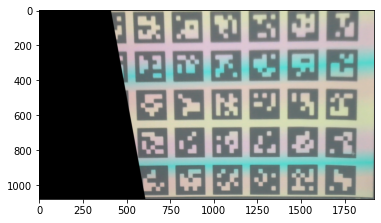

In [26]:
# check if everything is OK
screen_transformed = cv.warpPerspective(
    screen_picture, M, (1920, 1080)
)
plt.imshow(screen_transformed)
plt.show()

In [27]:
from ultralytics import YOLO
model = YOLO('best-2.pt')  # load a our model
names = model.names
names

{0: 'arrow',
 1: 'cross',
 2: 'ellipse',
 3: 'heart',
 4: 'line',
 5: 'rectangle',
 6: 'tick'}

In [149]:
img = cv.imread("./dataset/128.jpg")
results = model(img)

0: 384x640 1 rectangle, 127.6ms
Speed: 5.0ms preprocess, 127.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


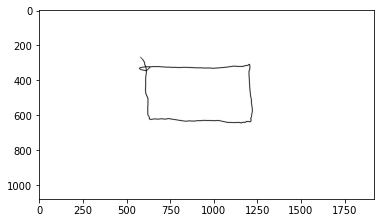

In [152]:
plt.imshow(img)

In [150]:
np.array(results[0].boxes.cls)

array([          5], dtype=float32)

In [151]:
np.array(results[0].boxes.xyxy[0]).astype('int')

array([ 559,  245, 1255,  674])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


((898.8033447265625, 462.4122314453125), (663.7755126953125, 356.6354675292969), 2.876765251159668)


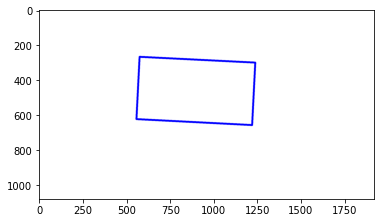

In [153]:
plt.imshow(recovery_figure(img, "rectangle"))

In [108]:
np.min(test_img_binary)

0

In [28]:
heart = cv.imread("./heart.jpg")

def recovery_figure(image, figure_type):

    image_binary = -((image[:,:,0] / 255) - 1).astype("uint8")
    kernel = np.ones((2,2),np.uint8)
    image_binary = cv.dilate(image_binary, kernel, iterations = 1)

    base = np.ones((1080, 1920, 3)) * 255
    contours,hierarchy = cv.findContours(image_binary, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rect = cv.minAreaRect(cnt)

    if figure_type == "rectangle":
        box = cv.boxPoints(rect) 
        box = np.int0(box)
        cv.drawContours(base,[box],-1, color=(0,0,0), thickness=10)
        return base
        
    if figure_type == "ellipse":
        (cx, cy),(lx, ly), th = rect
        cx = int(cx)
        cy = int(cy)
        lx = int(lx / 2)
        ly = int(ly / 2)
        th = int(th)
        # cv.ellipse(base, (cx, cy), (lx, ly), th, (0,0,255), 360, thickness=10)
        # return base

        center_coordinates = (cx, cy) 
        axesLength = (lx, ly)
        angle = th
        startAngle = 0
        endAngle = 360
        color = (0, 0, 0) 
        thickness = 10
        base = cv.ellipse(base, center_coordinates, axesLength, 
                angle, startAngle, endAngle, color, thickness) 
        return base
    
    if figure_type == "line":
        box = cv.boxPoints(rect) 
        box = np.int0(box)
        if np.sum((box[1]-box[0])**2) > np.sum((box[2]-box[1])**2):
            cv.drawContours(base,[box[0:2]],-1, color=(0,0,0), thickness=10)
        else:
            cv.drawContours(base,[box[1:3]],-1, color=(0,0,0), thickness=10)
        return base
    
    if figure_type == "cross":
        box = cv.boxPoints(rect) 
        box = np.int0(box)
        box1 = box[::2]
        box2 = box[1::2]
        cv.drawContours(base,[box1],-1, color=(0,0,0), thickness=10)
        cv.drawContours(base,[box2],-1, color=(0,0,0), thickness=10)
        return base
    
    if figure_type == "heart":
        return heart
    
    if figure_type == "arrow":
        # box = cv.boxPoints(rect) 
        # box = np.int0(box)
        # if np.sum((box[1]-box[0])**2) > np.sum((box[2]-box[1])**2):
        #     cv.drawContours(base,[np.array([(box[1] + box[2])/2, (box[0]+box[3])/2])],-1, color=(0,0,0), thickness=10)
        # else:
        #     cv.drawContours(base,[np.array([(box[0] + box[1])/2, (box[2]+box[3])/2])],-1, color=(0,0,0), thickness=10)
        return base
    
    if figure_type == "tick":
        
        return base

In [11]:
plt.imshow(results[0].plot())

NameError: name 'results' is not defined

In [29]:
# drawing itself
# drag the opened canvas to the desired screen
# to stop showing the image, press "q" inside the
# window with the drawn image
trajectories = []
i = 0
stop_flag = False
object_classes = []

while(True):
    canvas_full = np.ones((1080, 1920, 3)) * 255

    while(True):
        canvas_in_progress = canvas_full
        trajectory = []
        canvas_one_figure = np.ones((1080, 1920, 3)) * 255

        # waiting for the first point in the trajectory,
        # after the first point we go to the next While
        while(True):
            ret, frame = vid.read()

            frame = cv.inRange(frame, (240, 253, 240), (255, 255, 255))
            Moments = cv.moments(frame)

            if Moments["m00"] > 1.0:
                x = Moments["m10"] / Moments["m00"]
                y = Moments["m01"] / Moments["m00"]
                # too many casts to int, but it works :)
                pts = cv.perspectiveTransform(np.float32([[x,y]]).reshape(-1,1,2), M).astype(int)
                trajectory.append((int(pts[0][0][0]), int(pts[0][0][1])))
                break

            cv.imshow('frame', canvas_one_figure)
            if cv.waitKey(1) & 0xFF == ord('q'):
                stop_flag = True
                break

        # drawing lines between detected points
        while(True):
            ret, frame = vid.read()

            frame = cv.inRange(frame, (240, 253, 240), (255, 255, 255))
            Moments = cv.moments(frame)
            if Moments["m00"] > 1.0:
                x = Moments["m10"] / Moments["m00"]
                y = Moments["m01"] / Moments["m00"]
            else:
                trajectories.append(trajectory)
                class_detection = model(canvas_one_figure)
                if np.size(np.array(class_detection[0].boxes.cls)) != 0:
                    c = names[int(class_detection[0].boxes.cls[0])]
                    # bbox = np.array(results[0].boxes.xyxy[0]).astype('int')
                    print(c)
                    figure_recoveried = recovery_figure(canvas_one_figure, c)
                    for _ in range(30):
                        cv.imshow('frame', figure_recoveried)
                        if cv.waitKey(1) & 0xFF == ord('q'):
                            stop_flag = True
                            break
                break
            pts = cv.perspectiveTransform(np.float32([[x,y]]).reshape(-1,1,2), M).astype(int)
            trajectory.append((int(pts[0][0][0]), int(pts[0][0][1])))
            cv.line(canvas_one_figure, trajectory[-2], trajectory[-1], (0, 0, 0), 4)

            cv.imshow('frame', canvas_one_figure)
            if cv.waitKey(1) & 0xFF == ord('q'):
                stop_flag = True
                break
        if stop_flag:
            break

        # figure_recoveried = np.ones((1080, 1920, 3)) * 255
        # while(True):
        #     cv.imshow('frame', figure_recoveried)
        #     if cv.waitKey(1) & 0xFF == ord('q'):
        #         stop_flag = True
        #         break

    if stop_flag:
            break
cv.destroyAllWindows()


0: 384x640 1 line, 293.7ms
Speed: 40.5ms preprocess, 293.7ms inference, 32.6ms postprocess per image at shape (1, 3, 384, 640)
line

0: 384x640 (no detections), 214.5ms
Speed: 24.3ms preprocess, 214.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 line, 205.0ms
Speed: 24.3ms preprocess, 205.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
line

0: 384x640 1 rectangle, 187.7ms
Speed: 23.3ms preprocess, 187.7ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
rectangle

0: 384x640 1 heart, 200.2ms
Speed: 24.3ms preprocess, 200.2ms inference, 8.2ms postprocess per image at shape (1, 3, 384, 640)
heart

0: 384x640 (no detections), 218.0ms
Speed: 24.2ms preprocess, 218.0ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 heart, 197.9ms
Speed: 24.2ms preprocess, 197.9ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
heart

0: 384x640 (no detections), 188.7ms
Speed: 24.3ms pr

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\core\src\arithm.cpp:1726: error: (-215:Assertion failed) ! _src.empty() in function 'cv::inRange'


{0: 'arrow',
 1: 'cross',
 2: 'ellipse',
 3: 'heart',
 4: 'line',
 5: 'rectangle',
 6: 'tick'}

In [78]:
listochek = (1, 2, 3)
[*listochek]

[1, 2, 3]